# Рекуррентные сети пишут тексты
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ITMO][ML][MS][HW07] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит познакомиться с объединением Deep Learning и NLP. Для начала предстоит построить векторное пространство для словоря, а затем применить его для предсказания следующих слов в тексте.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import random
from math import sqrt
import json
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.neighbors import KDTree
from pathlib import Path
import pickle

from collections import Counter

SEED = 19

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DATA_PATH = Path("../data/opencorp.json")
START_TOKEN = "<START>"
END_TOKEN = "<END>"
UNK_TOKEN = "<UNKNOWN>"
SPECIAL_TOKENS = [START_TOKEN, END_TOKEN, UNK_TOKEN]

In [2]:
tokenized = json.load(open(DATA_PATH, "r", encoding="UTF-8"))

#### Задание 1 (3 балла)
Чтобы обучить нейронную сеть, нам нужен датасет. В данном задании предлагается использовать данные, полученные из корпуса текстов OpenCorpora. Более того, датасет нужно представить в удобном виде. Поскольку мы хотим обучать эмбеддинги на парах `(token_center, token_context)`, а также иметь возможность делать `negative sampling`, датасет должен уметь выдавать соответствующие пары, а так же `negative sampling`-токены. 

Кроме того, мы бы не хотели строить эмбеддинги для очень редких слов, поэтому в словарь и в пары должны входить только слова, которые встречаются более `count_threshold` раз, а остальные должны быть заменены на специальный токен `"<UNKNOWN>"`. Последовательность должна начинаться с токена `"<START>"` и заканчиваться токеном `"<END>"`.

#### Методы
`__init__` - принимает на вход список последовтельностей токенов, преобразуя в соответствии с описанными выше критериями. При инициализации списка токенов нужно учитывать, что с вероятностью $1 - (\sqrt{\frac{f(t)}{0.001}} + 1) \cdot \frac{0.001}{f(t)}$ ($f(t)$ - частота слова в корпусе) мы "выкидываем" слово из текста, не добавляя никакие пары токенов с его участием в список. Это нужно для того, чтобы мы не переобучались на часто встречаемые слова. Также в `self.voc` должен записать актуальный словарь токенов.

`__len__` - возвращает количество пар `(token_center, token_context)`

`__getitem__` - принимает на вход индекс `i`, соответствующий паре `(t_i, c_i)`. Возвращает пару тензоров `(t_i, [c_i] + negatives)`, где `negatives` - список негативных токенов.

`negative_sampling` - из уже существующего списка отрицательных примеров выбирает нужное количество негативных семплов.

`reset_negatives` - осуществляет взвешенное негативное сэмплирование. Вес токена определяется как $\frac{(count(t))^{0.75}}{\sum (count(t))^{0.75}}$, т.е. в negative samples частые слова попадают чаще, чем другие. Список полученных списков negative samples сохраняется в `self.negatives`.

In [3]:
class TokenDataset(Dataset):

    def __init__(self, tokenized_sources, window=3, count_threshold=5, k_negatives=5, neg_pool_size=1500):
        self.window = window
        self.count_threshold = count_threshold
        self.k_negatives = k_negatives
        self.neg_pool_size = neg_pool_size
        self.counts, self.total_words, self.dropped = \
          self.filter_tokens(self.get_counts(tokenized_sources))
        # В паре мест мне требуется фиксированный порядок
        self.voc = list(self.counts.keys())
        self.token_to_idx, self.idx_to_token = self.enum_tokens(self.counts)
        self.idx_voc = [self.lookup_idx(w) for w in self.voc]
        self.token_pairs = self.construct_pairs(tokenized_sources)
        self.negatives = None
        self.neg_samp_weights = self.get_neg_samp_weights()
        self.reset_negatives()

    def get_counts(self, tokenized_sources):
        counts = Counter({START_TOKEN: len(tokenized_sources),
                          END_TOKEN: len(tokenized_sources),
                          UNK_TOKEN:1})
        for text in tokenized_sources:
            for word in text:
                counts[word] += 1
        return counts

    def filter_tokens(self, counts):
        filtered = Counter()
        dropped = set()
        # Не знаю, надо ли вычитать частоты START и END
        total_words = sum(counts.values())
        new_total_words = 0
        for k, v in counts.items():
            if k in SPECIAL_TOKENS:
                filtered[k] = v
                continue
            # Dropping frequent words:
            freq = v / total_words
            prob = TokenDataset.get_drop_prob(freq)
            if random.random() < prob:
                dropped.add(k)
                continue
            # Rare words to unknown:
            if v <= self.count_threshold:
                filtered[UNK_TOKEN] += v
            else:
                filtered[k] = v
            new_total_words += v
        return filtered, new_total_words, dropped

    @staticmethod
    def get_drop_prob(freq, eps=0.001):
        return 1 - (sqrt(freq / eps) + 1) * (eps / freq)

    @staticmethod
    def enum_tokens(counts):
        token_to_idx = {}
        idx_to_token = {}
        for i, k in enumerate(counts.keys()):
            token_to_idx[k] = i
            idx_to_token[i] = k
        return token_to_idx, idx_to_token

    def construct_pairs(self, tokenized_source):
        token_pairs = []
        for text in tqdm(tokenized_source):
            text = [START_TOKEN] + text + [END_TOKEN]
            for i, word in enumerate(text):
                word_idx = self.lookup_idx(word)
                if (word_idx is None):
                    continue
                for w in self.context_at(text, i, self.window):
                    tmp = self.lookup_idx(w)
                    if tmp is not None:
                        token_pairs.append((word_idx, tmp))
        return np.array(token_pairs)

    @staticmethod
    def context_at(text, idx, window):
        return [w for w in text[max(0, idx - window):idx]] + \
               [w for w in text[idx+1:idx+window+1]]

    def lookup_idx(self, key):
        if key in self.counts.keys():
            return self.token_to_idx[key]
        if key in self.dropped:
            return None
        return self.token_to_idx[UNK_TOKEN]

    def get_neg_samp_weights(self):
        weights = []
        denom = sum(v ** 0.75 for v in self.counts.values())
        for word in self.idx_voc:
            weight = self.counts[self.idx_to_token[word]] ** 0.75 / \
                     denom
            weights.append(weight)
        return weights

    def negative_sampling(self):
        idx = np.random.randint(0,
                                self.neg_pool_size - 1,
                                size = (self.k_negatives,))
        return list(self.negatives[idx])
    
    def reset_negatives(self):
        self.negatives = np.random.choice(self.idx_voc,
                                          size = self.neg_pool_size,
                                          p = self.neg_samp_weights)
        
    def __getitem__(self, index):
        word, ctx = self.token_pairs[index]
        return (torch.LongTensor([word]),
                torch.LongTensor([ctx] + self.negative_sampling()))

    def __len__(self):
        return len(self.token_pairs)


def visual_test_token_dataset(dataset, test_size=10):
    for _ in range(test_size):
        idx = np.random.randint(0, len(dataset))
        center, ctx = dataset[idx]
        print(dataset.idx_to_token[center.item()])
        print(dataset.idx_to_token[ctx[0].item()])
        print([dataset.idx_to_token[idx.item()] for idx in ctx[1:]])


def save_dataset(dataset, save_path):
    with open(save_path, "wb") as ostream:
        pickle.dump(dataset, ostream)


def load_dataset(load_path):
    with open(load_path, "rb") as istream:
        return pickle.load(istream)


In [4]:
dataset = TokenDataset(tokenized)

In [5]:
# Кажется, сэмплы адекватные
visual_test_token_dataset(dataset)

собой
оставляя
['подарки', 'его', 'поездки', '<UNKNOWN>', 'по']
производственных
сделано
['годах', 'союз', 'сердец', '<UNKNOWN>', 'глубине']
другим
свою
['рукою', 'дать', '<UNKNOWN>', 'самые', 'слабая']
с
во
['женщин', 'само', 'женщин', 'любовь', 'хватает']
по
мере
['солдаты', 'углы', 'как', 'firefox', 'ничем']
ной
спутники
['так', 'было', 'востоке', ':)))', 'угол']
целом
иосиф
['следствие', 'написано', 'особь', '•', 'оптимистично']
%
+
['кризисом', 'пребывания', '!', '7', '9']
<UNKNOWN>
того
['именно', 'здоровое', 'продлится', 'общественности', 'что-то']
то
второго
['комары', 'наблюдением', 'ведется', 'программу', 'of']


### Задание 2 (4 балла)
Теперь реализуем непосредственно SkipGram. Для этого нам потребуются `torch.autograd.Variables` чтобы сделать эмбеддинги обучаемыми. Также сразу реализуем интерфейс, которым будем пользоваться для применения эмбеддингов в следующих задачах.

#### Методы SkipGram
`__init__` - принимает на вход словарь и размерность пространств эмбеддингов. Инициализирует эмбеддинги для центрального и контекстного слов.

`get_variables` - возвращает лист из всех `torch.autograd.Variables`. Необходимо, чтобы инициализировать оптимизатор.

`predict_proba(center_tokens, context_tokens)` - принимает на вход список центральных токенов и список списков токенов из предполагаемого контекста. Для каждого центрального токена и соответствующего ему списка контекстных токенов должен вернуть скалярное произведение центрального и контекстуального эмбеддингов.

#### Методы Embedding
`__init__` - принимает на вход обученный SkipGram

`embed` - возвращает эмбеддинги для всех элементов списка

`reconstruct` - для всех элементов списка возвращает наиболее подходящий токен. Не возвращает `"<UNKNOWN>"`

`n_closest` - возвращает `n` ближайших токенов для каждого элемента списка. Не возвращает `"<UNKNOWN>"`

In [6]:
class SkipGram(nn.Module):

    # Изменил немного сигнатуру, нужен не voc, а dataset целиком
    def __init__(self, dataset, latent_size):
        super().__init__()
        self.id2token = dataset.idx_to_token
        self.token2id = dataset.token_to_idx
        self.center_emb = nn.Embedding(len(dataset.idx_voc), latent_size)
        self.ctx_emb = nn.Embedding(len(dataset.idx_voc), latent_size)
        
    def forward(self, centers, ctx):
        centers = self.center_emb(centers)
        ctx = self.ctx_emb(ctx)
        return torch.bmm(centers, ctx.transpose(-2, -1)).squeeze(-2)

    @property
    def device(self):
        return next(self.parameters()).device
    
class Embedding:

    def __init__(self, skip_gram):
        self.skip_gram = skip_gram
        self.emb_mat = next(skip_gram.center_emb.parameters()).data.detach().cpu().numpy()
        self.kd_tree = KDTree(self.emb_mat)
    
    def embed(self, tokens):
        indices = []
        for tok in tokens:
            if tok not in self.skip_gram.token2id.keys():
                tok = UNK_TOKEN
            idx = self.skip_gram.token2id[tok]
            indices.append(idx)
        with torch.no_grad():
            indices = torch.LongTensor(indices).to(self.skip_gram.device)
            return self.skip_gram.center_emb(indices)
    
    def reconstruct(self, embeddings):
        return self.n_closest(embeddings, 1)

    def n_closest(self, embeddings, n=5):
        if not isinstance(embeddings, np.ndarray):
            embeddings = np.array(embeddings)
        _, closest_idx = self.kd_tree.query(embeddings, k = n + 1)
        closest_tokens = []
        for curr in closest_idx:
            as_tokens = [self.skip_gram.id2token[idx] for idx in curr]
            if UNK_TOKEN in as_tokens:
                as_tokens.remove(UNK_TOKEN)
            else:
                as_tokens = as_tokens[:-1]
            closest_tokens.append(as_tokens)
        return closest_tokens


def smoke_test_skip_gram_emb(dataset):
    skip_gram = SkipGram(dataset, 256)
    embed = Embedding(skip_gram)
    assert torch.all(embed.embed([UNK_TOKEN]) == \
                     skip_gram.center_emb(torch.LongTensor([dataset.token_to_idx[UNK_TOKEN]]))).item()
    assert embed.reconstruct(embed.embed([START_TOKEN, END_TOKEN])) == [[START_TOKEN], [END_TOKEN]]
    assert [lst[0] for lst in embed.n_closest(embed.embed([START_TOKEN, END_TOKEN]))] == \
           [START_TOKEN, END_TOKEN]
    assert embed.reconstruct(embed.embed([UNK_TOKEN])) != [[UNK_TOKEN]]
    assert [UNK_TOKEN] not in embed.n_closest(embed.embed([UNK_TOKEN]))


smoke_test_skip_gram_emb(dataset)

In [7]:
def make_checkpoint(model, opt, epoch, loss, save_dir_path, model_name, save_idx):
    save_path = Path(f"{model_name}_{save_idx}.tar")
    save_path = save_dir_path / save_path
    torch.save({'model_state_dict': model.state_dict(),
                'opt_state_dict': opt.state_dict(),
                'epoch': epoch,
                'loss': loss},
                save_path)


def log_loss(log_path, epoch, loss_val):
    with open(log_path, "a") as ostream:
        ostream.write(f"{epoch}\t{loss_val}\n")


SAVE_DIR = Path("../results/")
DATASET_PATH = SAVE_DIR / Path("token_dataset.pkl")
LOG_PATH = SAVE_DIR / Path("skipgram_log.tsv")


SAVE_FREQ = 1
N_LAST_SAVE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4096
EPOCHS = 200

print("Creating dataset...")
dataset = TokenDataset(tokenized, count_threshold=10, window=4, k_negatives=10)
save_dataset(dataset, DATASET_PATH)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
print("Creating skipgram...")
skipgram = SkipGram(dataset, 150).to(DEVICE)
optim = torch.optim.Adam(skipgram.parameters(), lr=1e-3)
y = torch.tensor([0] * (BATCH_SIZE + 1), dtype=torch.long, device=DEVICE)
losses = []
n_saves = 0
log_loss(LOG_PATH, "Epoch", "Loss")

for i in range(EPOCHS):
    avg_loss = 0
    steps = 0
    for batch in tqdm(dataloader):
        probs = skipgram(batch[0].to(DEVICE),
                         batch[1].to(DEVICE))
        loss = F.cross_entropy(probs, y[:probs.shape[0]])
        optim.zero_grad()
        loss.backward()
        optim.step()
        avg_loss += loss.item()
        steps += 1
    if i % 5 == 0:
        dataset.reset_negatives()
    if i % SAVE_FREQ == 0:
        make_checkpoint(skipgram,
                        optim,
                        i,
                        avg_loss / steps,
                        SAVE_DIR,
                        "skipgram",
                        n_saves % N_LAST_SAVE)
        n_saves += 1
    losses.append(avg_loss/steps)
    print("Loss:", avg_loss/steps)
    log_loss(LOG_PATH, i, avg_loss / steps)


Creating dataset...



Creating skipgram...



Loss: 7.935229511659686



Loss: 3.6163328807716186



Loss: 1.3201831208320196



Loss: 0.9150106026949212



Loss: 0.8026298535052588



Loss: 0.7562593790789779



Loss: 1.948694483986449



Loss: 0.8605587407473799



Loss: 0.7767923027555104



Loss: 0.7377508251068083



Loss: 0.7147879022055039



Loss: 1.37018539561581



Loss: 0.752398787327069



Loss: 0.7020550711513589



Loss: 0.6758477837570392



Loss: 0.659425639247396



Loss: 1.1984528615742578



Loss: 0.7722397854453639



Loss: 0.7385311906530858



Loss: 0.7201171584118654



Loss: 0.7080532645235849



Loss: 1.0547640832024932



Loss: 0.6914843602294395



Loss: 0.6647606568578555



Loss: 0.6497428222528453



Loss: 0.6394988965213899



Loss: 0.9818409965437889



Loss: 0.6729431189054338



Loss: 0.651262005637412



Loss: 0.6390034317213815



Loss: 0.6307226372948775



Loss: 1.0155854625860317



Loss: 0.7417922828036397



Loss: 0.721983444294675



Loss: 0.7109275274465403



Loss: 0.7031214021621867



Loss: 0.947573012538524



Loss: 0.6914331390814089



Loss: 0.6741150499013165



Loss: 0.6642964678764699



Loss: 0.6571633913660281



Loss: 0.9144591256369846



Loss: 0.6804577437920907



Loss: 0.664935206490339



Loss: 0.6563716595543992



Loss: 0.6501630234291145



Loss: 0.9094906570129139



Loss: 0.6862551939714395



Loss: 0.6714599315645803



Loss: 0.6632111936907752



Loss: 0.6575498639892046



Loss: 0.9001899078160179



Loss: 0.6799105825643122



Loss: 0.6654079772056417



Loss: 0.6578068879612705



Loss: 0.6523327063428417



Loss: 0.9125564081671523



Loss: 0.6891801957320526



Loss: 0.6744354055549904



Loss: 0.6666974839811763



Loss: 0.6612407028697328



Loss: 0.8689837028794255



Loss: 0.6506174829923738



Loss: 0.636070698510804



Loss: 0.629066463547351



Loss: 0.6239680146583652



Loss: 0.8893676389505187



Loss: 0.6693318665316853



Loss: 0.6550177147068965



Loss: 0.6480470884197814



Loss: 0.642945636337753



Loss: 0.923570023249583



Loss: 0.7098286940384908



Loss: 0.6957324275155261



Loss: 0.6887888370854234



Loss: 0.6840795571343941



Loss: 0.8678171130292849



Loss: 0.6491609847825959



Loss: 0.6348106495343557



Loss: 0.6279147446444783



Loss: 0.6233203913258634



Loss: 0.9089100368212479



Loss: 0.6872512685269195



Loss: 0.6727686096323475



Loss: 0.6655636958419142



Loss: 0.6609092263999204



Loss: 0.8865270942794427



Loss: 0.6589517060969027



Loss: 0.6442495372456462



Loss: 0.6376360382950097



Loss: 0.6328415159593549



Loss: 0.8538836555589532



Loss: 0.6349698540077765



Loss: 0.6209255692762152



Loss: 0.6143441079890118



Loss: 0.610062628394857



Loss: 0.873727489002786



Loss: 0.6519203968971867



Loss: 0.6379742314896507



Loss: 0.6312833659993308



Loss: 0.6270664891408156



Loss: 0.8921361288146858



Loss: 0.6752177296222347



Loss: 0.6613468217200066



Loss: 0.655239590672069



Loss: 0.6509984431092354



Loss: 0.9144802315326803



Loss: 0.6853991593607952



Loss: 0.6713941575387112



Loss: 0.6646912450797525



Loss: 0.6605167261652646



Loss: 0.8970798412647297



Loss: 0.6678944048974086



Loss: 0.6536211959013702



Loss: 0.6471883897996741



Loss: 0.6431619439408957



Loss: 0.8475700734532916



Loss: 0.6127800754354533



Loss: 0.598132616038997



Loss: 0.5917830409377135



Loss: 0.5873154900153211



Loss: 0.8991423101289898



Loss: 0.677793458643668



Loss: 0.6634233531866469



Loss: 0.6568192522799003



Loss: 0.6527670285246986



Loss: 0.8819468028957428



Loss: 0.6522242344106566



Loss: 0.6376594438309009



Loss: 0.6314526157131743



Loss: 0.6271953184286931



Loss: 0.877432669107929



Loss: 0.6637808674527176



Loss: 0.6495420295340484



Loss: 0.6430335274246389



Loss: 0.6393498287533771



Loss: 0.8579589013690244



Loss: 0.6566033512187031



Loss: 0.6431385896774583



Loss: 0.6368705453201655



Loss: 0.6330858970943251



Loss: 0.8347622143238861



Loss: 0.642709376029712



Loss: 0.629675883194901



Loss: 0.6237774739829672



Loss: 0.6200599399864251



Loss: 0.8565993210236142



Loss: 0.6590890127938823



Loss: 0.6460692306292862



Loss: 0.6399956700649667



Loss: 0.6362869646087339



Loss: 0.840200412580441



Loss: 0.6280455747706181



Loss: 0.6158590769313885



Loss: 0.6097783685931967



Loss: 0.6058820316755046



Loss: 0.8432166775735113



Loss: 0.6271182638622568



Loss: 0.6149513312087392



Loss: 0.6092589475984848



Loss: 0.6049561582870028



Loss: 0.8724240581684034



Loss: 0.6420177617105097



Loss: 0.6296794004029149



Loss: 0.6235343411637135



Loss: 0.6196794526129349



Loss: 0.9256612484292247



Loss: 0.6904596275427128



Loss: 0.6771519010126613



Loss: 0.6708848809920037



Loss: 0.666906968543404



Loss: 0.8880602897170231



Loss: 0.6526202364793773



Loss: 0.638973524784944



Loss: 0.6327948072767382



Loss: 0.6288308703485556



Loss: 0.9320432220033943



Loss: 0.7017925470210848



Loss: 0.6882144333978961



Loss: 0.6817394042246464



Loss: 0.6777082736610521



Loss: 0.8918167875524152



Loss: 0.6565230526155214



Loss: 0.6430114830283364



Loss: 0.6366111774994572



Loss: 0.6325528262577291



Loss: 0.8915729568092714



Loss: 0.6555574193468909



Loss: 0.6415806993391586



Loss: 0.6351638214718989



Loss: 0.6313903692855279



Loss: 0.8955457423462179



Loss: 0.6624608101485246



Loss: 0.6492209606492817



Loss: 0.6431733663956947



Loss: 0.6392402515655224



Loss: 0.8793181330688679



Loss: 0.6424356392845817



Loss: 0.6289283035183273



Loss: 0.6225288225982384


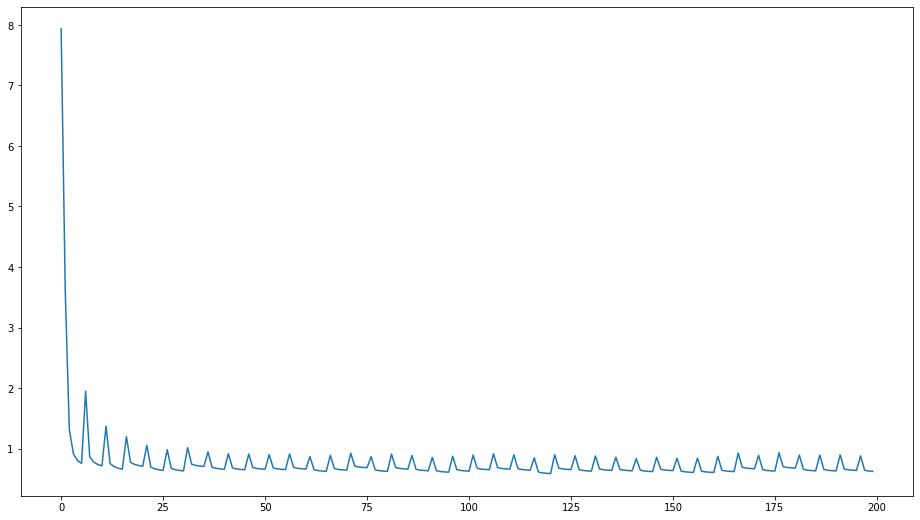

In [10]:
fig, ax = plt.subplots(figsize=[16, 9])
ax.plot(list(range(EPOCHS)), losses)

In [7]:
def load_skipgram(dataset, checkpoint_path, device):
    skipgram = SkipGram(dataset, 150).to(device)
    state_dict = torch.load(checkpoint_path,
                            map_location = device)
    skipgram.load_state_dict(state_dict["model_state_dict"])
    return skipgram

In [9]:
dataset = load_dataset("../results/token_dataset.pkl")
skipgram = load_skipgram(dataset,
                         "../results/skipgram_19.tar",
                         torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [10]:
embedder = Embedding(skipgram)

Эмбеддинг, кажется, обучился на что-то более менее осмысленное.

In [11]:
king = embedder.embed(["король"])
cat = embedder.embed(["кошка"])
owl = embedder.embed(["сыч"])
give = embedder.embed(["дать"])
me = embedder.embed(["я"])
you = embedder.embed(["ты"])
print(embedder.n_closest(king.cpu(), 10)[0])
print(embedder.n_closest(cat.cpu(), 10)[0])
print(embedder.n_closest(owl.cpu(), 10)[0])
print(embedder.n_closest(give.cpu(), 10)[0])
print(embedder.n_closest(me.cpu(), 10)[0])
print(embedder.n_closest(you.cpu(), 10)[0])

['король', 'дмитрий', 'лидер', 'ii', 'отец', 'родился', 'президентом', 'бывший', 'объявил', 'институт']
['кошка', 'тени', 'г-н', 'доллар', 'еды', 'поняла', '1977', 'реализация', 'нету', 'солнце']
['-', 'по', 'его', 'их', 'к', 'ее', 'уже', 'не', 'или', 'все']
['дать', 'получить', 'найти', 'нам', 'стать', 'весь', 'свое', 'сделать', 'язык', 'развития']
['я', 'мы', 'он', 'вы', 'мне', 'так', 'это', 'бы', 'даже', 'уже']
['ты', 'я', 'мне', 'вот', 'да', 'всё', 'вообще', 'нам', 'вы', 'теперь']


### Задание 3 (2 балла)
Теперь будем учиться восстанавливать слова в тексте. Для этого нам потребуется также определить датасет последовательностей фиксированной длинны.

#### Методы
`__init__` - принимает на вход `embedder` (обученный SkipGram) и список токенизированных последоватлеьностей `tokenized`.

`__getitem__` - возвращает случайную закодированную при помощи SkipGram подпоследовательность длины `seq_len` одной из исходных последовательностей, сдвинутую на один токен подпоследовательность (т.е. следующие слова в тексте) и маску, которая отражает то, является ли токен неизвестным (`"<UNKNOWN"`).

`__len__` - равна количеству последовательностей.

In [30]:
class TokenSeqDataset(Dataset):

    def __init__(self, embedder, tokenized, seq_len=32):
        self.embedder = embedder
        self.tokenized = tokenized
        self.seq_len = seq_len
        self.token2id = self.embedder.skip_gram.token2id
        self.id2token = self.embedder.skip_gram.id2token
        self.indexed_data = [torch.LongTensor([self.lookup_token(START_TOKEN)] + \
                                              [self.lookup_token(tok) for tok in text] + \
                                              [self.lookup_token(END_TOKEN)]) \
                             for text in tokenized if len(text) + 2 >= seq_len + 1]

    def lookup_token(self, key):
        if key not in self.token2id.keys():
            return self.token2id[UNK_TOKEN]
        return self.token2id[key]

    def __len__(self):
        return len(self.indexed_data)

    def __getitem__(self, index):
        text_idx = np.random.randint(0, len(self))
        text = self.indexed_data[text_idx]
        start_idx = np.random.randint(0, len(text) - self.seq_len)
        seq = torch.LongTensor(text[start_idx:start_idx+self.seq_len+1])
        mask = (seq == self.token2id[UNK_TOKEN])[:-1]
        with torch.no_grad():
            device = self.embedder.skip_gram.device
            seq = self.embedder.skip_gram.center_emb(seq.to(device))
        inp = seq[:-1]
        labs = seq[1:]
        return inp, labs, mask


def smoke_test_token_seq_dataset(dataset):
    for i in range(1000):
        inp, labs, mask = dataset[i]
        assert len(inp) == len(labs)
        assert torch.any(inp != labs).item()


tokenseq_data = TokenSeqDataset(embedder, tokenized)
smoke_test_token_seq_dataset(tokenseq_data)

### Задание 4 (2 балла)
Теперь обучим рекуррентную сеть, которая будет предсказывать следующее слово в тексте. Модель будет состоять из трех блоков: `input` (отвечает за предоброботку эмбеддинга), `rnn` (рекуррентная часть), `output` (отвечает за постобработку выхода).

#### Методы
`predict_sequential` - возвращает последовательность предсказаний для батча последовательностей

`get_next` - предсказывает следующее слово

`reset` - обнуляет внутреннее состояние сети

In [96]:
class TextRNN(nn.Module):

    def __init__(self,
                 latent_space=150,
                 hidden_layer=256,
                 num_layers=1):
        super().__init__()
        self.latent_space = latent_space
        self.hidden_layer = hidden_layer
        self.num_layers = num_layers
        self.input = nn.Linear(latent_space, hidden_layer)
        self.activation = nn.ReLU()
        self.rnn = nn.LSTM(hidden_layer,
                           hidden_layer,
                           num_layers=num_layers,
                           batch_first=False)
        self.output = nn.Linear(hidden_layer, latent_space)
        self.hidden = None

    def forward(self, batch):
        batch = self.activation(self.input(batch))
        batch, self.hidden = self.rnn(batch, self.hidden)
        return self.output(batch)

    def get_next(self, batch):
        with torch.no_grad():
            out = self(batch)
        return out[:,-1] if self.rnn.batch_first else out[-1]

    def reset(self, batch_size):
        self.hidden = [torch.zeros((self.num_layers,
                                    batch_size,
                                    self.hidden_layer)).to(self.device)\
                       for _ in range(2)]

    @property
    def device(self):
        return next(self.parameters()).device


Сейчас в этой ячейке уже код, который обучал немного другую архитектуру, он поэтому и прерван. По времени не успел, так что оставил предыдущую, которая в ячейке выше. Под ячейкой эта модель подругжается.

In [95]:
def make_checkpoint(model, opt, epoch, loss, save_dir_path, model_name, save_idx):
    save_path = Path(f"{model_name}_{save_idx}.tar")
    save_path = save_dir_path / save_path
    torch.save({'model_state_dict': model.state_dict(),
                'opt_state_dict': opt.state_dict(),
                'epoch': epoch,
                'loss': loss},
                save_path)


def log_loss(log_path, epoch, loss_val):
    with open(log_path, "a") as ostream:
        ostream.write(f"{epoch}\t{loss_val}\n")


def log_losses(epoch, values, files, write_code="a"):
    for f, v in zip(files, values):
        with open(f, write_code) as ostream:
            ostream.write(f"{epoch}\t{v}\n")

def merge_generators(*args):
    for arg in args:
        for v in arg:
            yield v

BATCH_SIZE = 64
EPOCHS = 200

SAVE_FREQ = 1
N_LAST_SAVE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_DIR = Path("../results/")
DATASET_PATH = SAVE_DIR / Path("tokenseq_dataset_2.pkl")
LOG_LOSS_PATH = SAVE_DIR / Path("rnn_log_2.tsv")
LOG_ACC1_PATH = SAVE_DIR / Path("rnn_top1_acc_2.tsv")
LOG_ACC5_PATH = SAVE_DIR / Path("rnn_top5_acc_2.tsv")
LOG_PATHS = [LOG_LOSS_PATH, LOG_ACC1_PATH, LOG_ACC5_PATH]

tokenseq_dataset = TokenSeqDataset(embedder, tokenized)
save_dataset(tokenseq_dataset, DATASET_PATH)

dataloader = DataLoader(tokenseq_dataset, batch_size=BATCH_SIZE, shuffle=True)
rnn = TextRNN(num_layers=5).to(DEVICE)
optim = torch.optim.Adam(rnn.parameters(), lr=1e-3)

losses = []
top1accs = []
top5accs = []
log_losses("Epoch",
           ["Loss", "Top1Acc", "Top5Acc"],
           LOG_PATHS,
           write_code = "w")
n_saves = 0
for i in range(EPOCHS):
    avg_loss = 0
    top1acc = 0
    top5acc = 0
    steps = 0
    acc_steps = 0
    for x, y_true, loss_mask in tqdm(dataloader):
        x = x.transpose(0, 1).to(DEVICE)
        y_true = y_true.transpose(0, 1).to(DEVICE)
        
        rnn.reset(x.shape[1])
        y_pred = rnn(x)
        loss = nn.MSELoss()(y_pred, y_true)
        optim.zero_grad()
        loss.backward()
        optim.step()
        avg_loss += loss.item()
        steps += 1

        if steps % 100 == 0:
            acc_steps += 1
            word_pred = embedder.n_closest(y_pred.detach().view(-1, 150)[:200].cpu().numpy())
            word_true = embedder.reconstruct(y_true.detach().view(-1, 150)[:200].cpu().numpy())
            unknown_mask = loss_mask.view(-1).cpu().numpy()
            t1a = 0
            t5a = 0
            for true, pred, is_unknown in zip(word_true, word_pred, unknown_mask):
                if is_unknown:
                    continue
                if true == pred[0]:
                    t1a += 1
                if true in pred:
                    t5a += 1
            top1acc += t1a / len(word_pred)
            top5acc += t5a / len(word_pred)
    losses.append(avg_loss/steps)
    top1accs.append(top1acc/acc_steps)
    top5accs.append(top5acc/acc_steps)
    print("Loss:", avg_loss/steps)
    print("Top-1 accuracy:", top1acc/acc_steps)
    print("Top-5 accuracy:", top5acc/acc_steps)
    log_losses(i,
               [avg_loss / steps, top1acc / acc_steps, top5acc / acc_steps],
               LOG_PATHS)
    if i % SAVE_FREQ == 0:
        make_checkpoint(rnn,
                        optim,
                        i,
                        avg_loss / steps,
                        SAVE_DIR,
                        "rnn2",
                        n_saves % N_LAST_SAVE)
        n_saves += 1


Loss: 0.06477437221730678
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.0640333464374515
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06329956935734667
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06299905161931044
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06307014815487971
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.0627331821872375
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06303546435725381
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06247364047562495
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06230290394201661
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.062386523558622106
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06216328127848726
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06211434488310172
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06201804394067871
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.061803604745677004
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.061823699185704774
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.0613644370611725
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.061434080979031615
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.061436043673309695
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06118234048429396
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06108250156215747
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.0606861300126017
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06079234978061351
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06084029932631804
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06059266462452432
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.060356793909154854
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.06031588717953523
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.060093396596802684
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.060008180933473446
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.05988524680193994
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.060007676845122884
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.05940611685031123
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.05948979499346889
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.05924239448327731
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0



Loss: 0.05933587796409697
Top-1 accuracy: 0.0
Top-5 accuracy: 0.0


KeyboardInterrupt: 

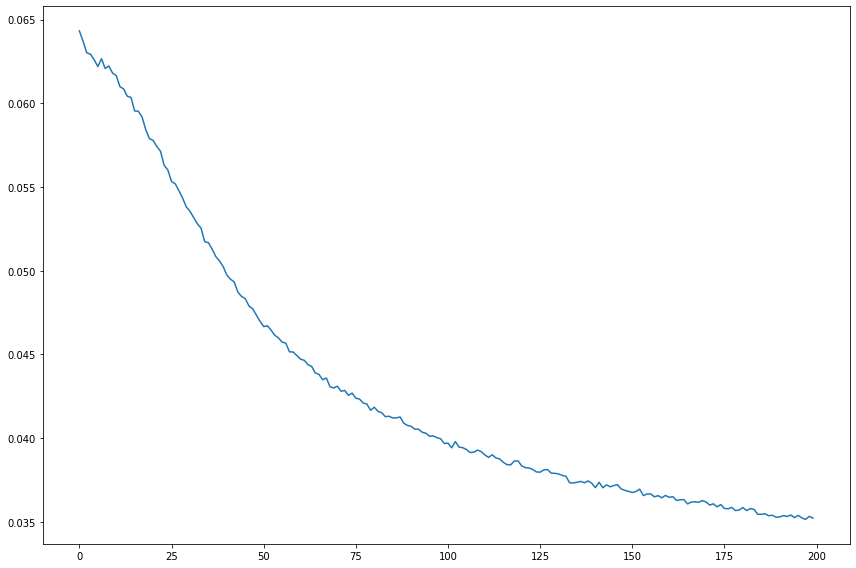

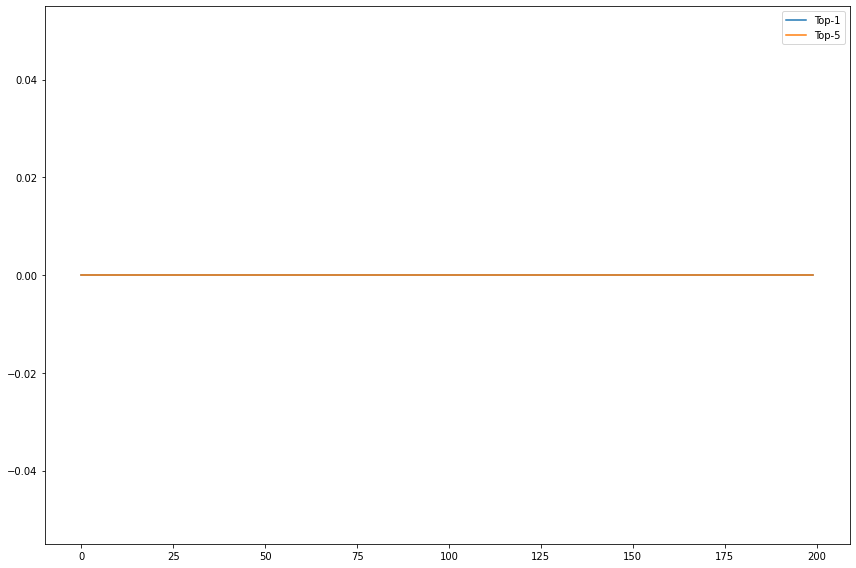

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(EPOCHS)), losses)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
plt.plot(list(range(200)), top1accs, label="Top-1")
plt.plot(list(range(200)), top5accs, label="Top-5")
plt.legend()
plt.tight_layout()
plt.show()

### Задание 5 (1 балл)
Отлично, осталось только научитсья итеративно продолжать последовательность. Давайте попробуем научиться это делать.

#### Методы
`continue_sequence` - возвращает завершенную последовательность. Входная последовательность может быть пустой, поэтому в начало нужно добавить токен `"<START>"`. Закончить построение последовательности нужно после получения токена `"<END>"` или после получения `max_len` новых слов.

In [97]:
class SequenceCompleter:

    def __init__(self, rnn, embedder, max_len=128):
        self.rnn = rnn
        self.embedder = embedder
        self.max_len = max_len
        
    def continue_sequence(self, sequence, n_closest=5):
        sequence = [START_TOKEN] + sequence
        rnn.reset(1)
        with torch.no_grad():
            for i in range(self.max_len):
                if i == 0:
                    inp = embedder.embed(sequence).unsqueeze(1)
                else:
                    inp = last_pred.unsqueeze(1)
                last_pred = rnn.get_next(inp)
                idx = np.random.randint(0, n_closest)
                pred = embedder.n_closest(last_pred.detach().cpu().numpy(),
                                          n_closest)[0]
                sequence.append(pred[idx])
                if pred[idx] == END_TOKEN:
                    break
        return sequence

In [108]:
rnn = TextRNN(hidden_layer=512,
              num_layers=5).to(DEVICE)
rnn.load_state_dict(torch.load("../results/rnn_19.tar")["model_state_dict"])
skipgram = SkipGram(dataset, 150).to(DEVICE)
skipgram.load_state_dict(torch.load("../results/skipgram_19.tar")["model_state_dict"])
embedder = Embedding(skipgram)

Модель не дообучилась, плюс видно влияние частых слов типа предлогов и местоимений. Возможно, стоит попробовать другие гиперпарметры в архитектуре. Можно еще попробовать продолжать обучать эмбеддинги, уже на таск language model.

In [109]:
seq_completer = SequenceCompleter(rnn, embedder)
print(seq_completer.continue_sequence(["учеба", "в", "магистратуре", "-", "это"]))
print(seq_completer.continue_sequence(["работает", "ли", "наша", "простая", "модель", "?"]))
print(seq_completer.continue_sequence(["я", "точно", "знаю"]))
print(seq_completer.continue_sequence(["машина", "времени"]))
print(seq_completer.continue_sequence(["сегодня"]))
print(seq_completer.continue_sequence([]))

['<START>', 'учеба', 'в', 'магистратуре', '-', 'это', 'цена', 'здесь', 'объекта', '-', 'их', 'раньше', 'по', 'его', '-', 'сша', 'только', 'тоже', '-', 'россия', 'уже', 'все', 'его', 'уже', 'его', '-', 'мид', 'его', 'только', 'его', 'его', 'их', 'по', '-', 'вообще', 'по', '-', 'уже', 'даже', 'его', '-', '-', 'его', 'сша', '-', '-', 'их', '-', 'очень', 'его', 'уже', 'функций', 'по', 'сша', 'его', 'их', 'польши', 'по', 'даже', '-', '-', 'к', '-', 'их', '-', 'тоже', 'его', 'уже', 'программ', 'их', 'его', 'его', 'по', 'моим', '-', '-', 'его', '-', 'его', 'их', '-', 'по', 'уже', 'акта', 'по', '-', 'сша', 'их', 'все', 'к', '-', 'к', 'по', 'уже', 'российский', 'по', 'вообще', 'по', 'значительной', 'их', 'уже', 'уже', 'тоже', '-', 'к', 'его', 'его', 'по', 'к', 'их', 'уже', 'по', 'к', '-', 'уже', 'даже', 'по', '-', 'уже', 'его', '-', '-', 'их', 'программ', 'по', 'даже', '-', 'по', 'российский', 'его', 'его', 'уже', 'его', 'вообще']
['<START>', 'работает', 'ли', 'наша', 'простая', 'модель', '?', 